In [3]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [5]:
# cap = cv2.VideoCapture(0)
#
# cap.set(3,1280)
# cap.set(4,1024)
# cap.set(10,128)
# cap.set(11,32)
# cap.set(12,32)


# print("frame width: " + str(cap.get(3)))
# print("frame height: " + str(cap.get(4)))
# print("--------------------------------")
# print("brightness: " + str(cap.get(10)))
# print("contrast: " + str(cap.get(11)))
# print("saturation: " + str(cap.get(12)))
# print("--------------------------------")
# print("gain: " + str(cap.get(14)))
# print("exposure: " + str(cap.get(15)))
# print("--------------------------------")
# print("white balance: " + str(cap.get(17)))

# for i in range(0, 10):
#     ret, frame = cap.read()
#     grayscale = rgb2gray(frame)
#     fig, ax = plt.subplots(figsize=(8, 4))
#     ax.imshow(grayscale, cmap=plt.cm.gray)
#     ax.set_title("Grayscale")
#     plt.show()
#     cv2.imwrite(f"Weiss{i}.png", frame)

# Aufgabe 1: Aufnahme und Analyse eines Grauwertkeiles

In [7]:
def read_image(path):
    img = cv2.imread(path)
    return img

In [8]:
def read_image_as_double(path):
    return cv2.imread(path, cv2.IMREAD_GRAYSCALE).astype(np.float64)

In [9]:
def convert_to_grayscale(image):
    # BGR statt RGB siehe: https://docs.opencv.org/4.x/d4/da8/group__imgcodecs.html
    gray_img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return gray_img

In [10]:
def show_cv2_as_image(image, titel="Bild"):
    plt.figure()
    plt.title(titel)
    if len(image.shape) == 2:  # Graustufenbild
        plt.imshow(image, cmap='gray')
    else:  # Farbbild
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

In [11]:
def extract_sub_images(gray_img, steps = 6):
    height, width = gray_img.shape
    step_size = 256 // steps
    sub_images = []

    for i in range(steps):
        min_val = i * step_size
        max_val = (i + 1) * step_size - 1
        # Maske für Pixel im Grauwertbereich [min_val, max_val]
        mask = cv2.inRange(gray_img, min_val, max_val)
        sub_image = cv2.bitwise_and(gray_img, gray_img, mask=mask)
        sub_images.append(sub_image)

    return sub_images

In [12]:
def calculate_mean(values):
    non_zero_pixels = [int(pixel) for pixel in values.flatten() if pixel > 0]
    if len(non_zero_pixels) == 0:
        return 0
    sum_values = 0
    for v in non_zero_pixels:
        sum_values += v
    return sum_values / len(non_zero_pixels)

In [13]:
def calculate_std_dev(values, mean):
    non_zero_values = [pixel for pixel in values.flatten() if pixel > 0]
    if len(non_zero_values) == 0:
        return 0
    sum_squared_diff = 0
    for value in non_zero_values:
        sum_squared_diff += (value - mean) ** 2
    variance = sum_squared_diff / len(non_zero_values)
    return variance ** 0.5

In [14]:
def calculate_statistics(sub_images):
    stats = []

    for index, sub_image in enumerate(sub_images):
        mean_val = calculate_mean(sub_image)
        std_dev = calculate_std_dev(sub_image, mean_val)

        stats.append((index, mean_val, std_dev))

    return stats

In [15]:
def create_table(stats):
    print("{:<10} {:<15} {:<20}".format('Stufe', 'Mittelwert', 'Standardabweichung'))
    for stat in stats:
        print("{:<10} {:<15} {:<20}".format(stat[0], round(stat[1], 2), round(stat[2], 2)))

Stufe      Mittelwert      Standardabweichung  
0          41.01           5.0                 
1          80.41           6.54                
2          126.19          7.84                
3          173.07          9.16                
4          222.63          5.92                


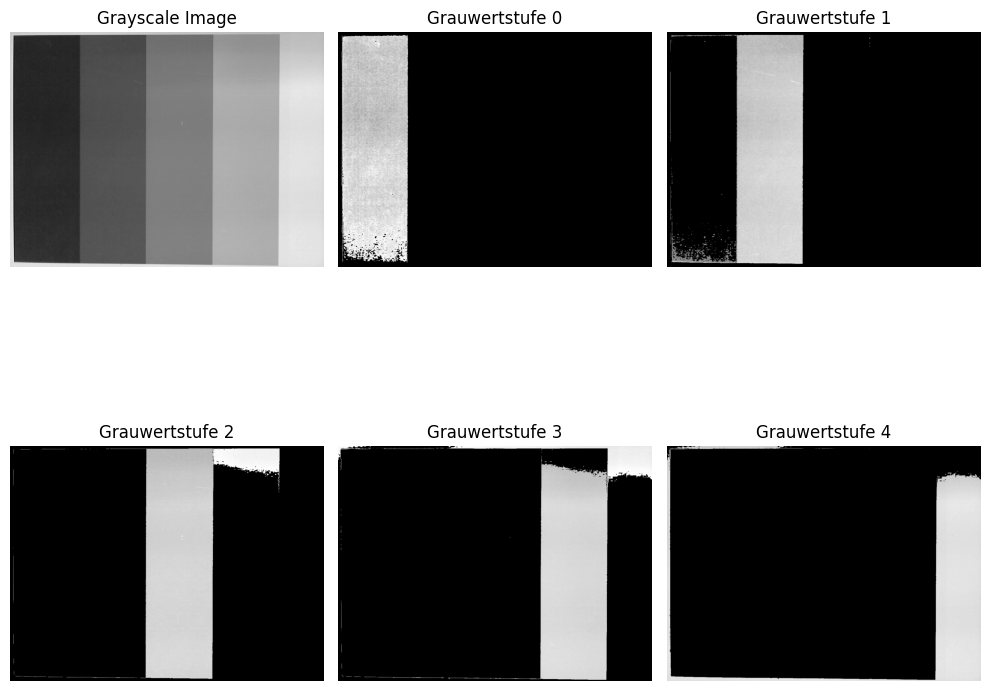

In [16]:
image_path = "Gray.png"

original_image = read_image(image_path)
grayscaled_image = convert_to_grayscale(original_image)

subimages = extract_sub_images(grayscaled_image, 5)

statistics = calculate_statistics(subimages)
create_table(statistics)

plt.figure(figsize=(10, 10))
plt.subplot(2, 3, 1)
plt.imshow(grayscaled_image, cmap='gray')
plt.title("Grayscale Image")
plt.axis('off')

for i, s in enumerate(subimages):
    plt.subplot(2, 3, i + 2)
    plt.imshow(s, cmap='gray')
    plt.title(f"Grauwertstufe {i}")
    plt.axis('off')

plt.tight_layout()
plt.show()

cv2.waitKey(0)
cv2.destroyAllWindows()

#Aufgabe 2: Aufnahme eines Dunkelbildes

Einlesen der 10 Dunkelbilder

In [17]:
def read_images(paths):
    images = []
    for path in paths:
        images.append(read_image_as_double(path))
    return images

Mittelwertberechnung der Dunkelbilder

In [18]:
def calculate_images_mean(images):
    sum_image = np.zeros_like(images[0])
    for image in images:
        sum_image += image
    mean_image = sum_image / len(images)
    return mean_image

Kontrastmaximierte Darstellung des Dunkelbilds

In [19]:
def show_dark_image(dark_image):
    # Normalisieren des Dunkelbilds für maximale Kontrasteinstellung
    normalized_image = cv2.normalize(dark_image, None, 0, 255, cv2.NORM_MINMAX)
    cv2.imwrite("Dunkelbild.png", normalized_image)
    plt.imshow(normalized_image, cmap='gray')
    plt.title("Dunkelbild (kontrastmaximiert)")
    plt.axis('off')
    plt.show()

Routine zur Korrektur eines Eingabebilds mittels Dunkelbild

In [20]:
def correct_image(input_image_path, dark_image):
    # Eingabebild einlesen und in float64 umwandeln
    input_image = cv2.imread(input_image_path, cv2.IMREAD_GRAYSCALE).astype(np.float64)

    # Dunkelbild subtrahieren und sicherstellen, dass keine negativen Werte auftreten
    corrected_image = input_image - dark_image
    corrected_image[corrected_image < 0] = 0

    # Zurück in uint8 umwandeln, damit das Bild korrekt gespeichert werden kann
    corrected_image = corrected_image.astype(np.uint8)
    return corrected_image

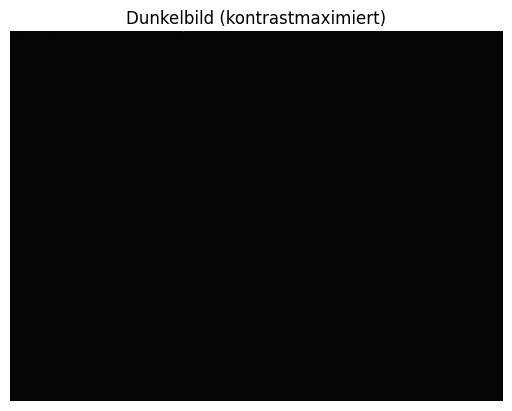

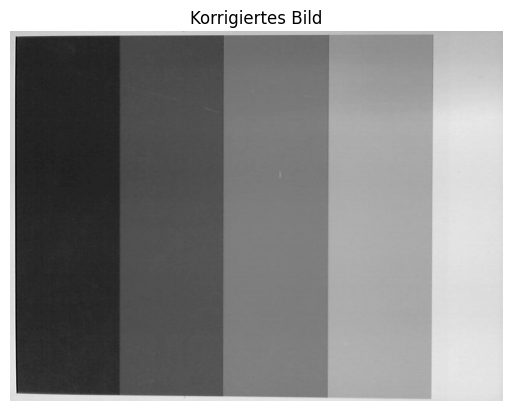

In [21]:
dark_image_paths = [f"Dunkel/Dunkel{i}.png" for i in range(10)]  # Pfade der Dunkelbilder anpassen
dark_images = read_images(dark_image_paths)

mean_dark_image = calculate_images_mean(dark_images)

# Dunkelbild kontrastmaximiert darstellen
show_dark_image(mean_dark_image)

# Eingabebild einlesen und korrigieren
corrected_image = correct_image("Gray.png", mean_dark_image)

show_cv2_as_image(corrected_image, "Korrigiertes Bild")

# Aufgabe 3: Aufnahme eines Weißbildes

Subtrahieren des Dunkelbildes vom Mittelwert-Weißbild und Kontrastmaximierung

In [22]:
def process_white_image(mean_white_image, dark_image):
    # Dunkelbild vom Weißbild abziehen
    white_corrected = mean_white_image - dark_image
    white_corrected[white_corrected < 0] = 0

    # Weißbild kontrastmaximiert darstellen und speichern
    normalized_white = cv2.normalize(white_corrected, None, 0, 255, cv2.NORM_MINMAX)
    cv2.imwrite("Weissbild.png", normalized_white)
    plt.imshow(normalized_white, cmap='gray')
    plt.title("Weissbild (kontrastmaximiert)")
    plt.axis('off')
    plt.show()

    return white_corrected

Normieren des Weißbildes auf Mittelwert 1

In [23]:
def normalize_white_image(white_image):
    mean_val = calculate_mean(white_image)
    if mean_val == 0:
        mean_val = 1
    normalized_white = white_image / mean_val
    normalized_white[normalized_white == 0] = 1
    return normalized_white

Routine zur erweiterten Korrektur eines Eingabebilds mittels Dunkelbild und Weißbild

In [24]:
def correct_image_with_white(input_image_path, dark_image, white_image):
    input_image = read_image_as_double(input_image_path)

    # Dunkelbild subtrahieren
    corrected_image = input_image - dark_image
    corrected_image[corrected_image < 0] = 0

    # Division durch das normierte Weißbild
    corrected_image = corrected_image / white_image
    corrected_image[corrected_image > 255] = 255

    # Zurück in uint8 umwandeln, damit das Bild korrekt gespeichert werden kann
    corrected_image = corrected_image.astype(np.uint8)
    return corrected_image

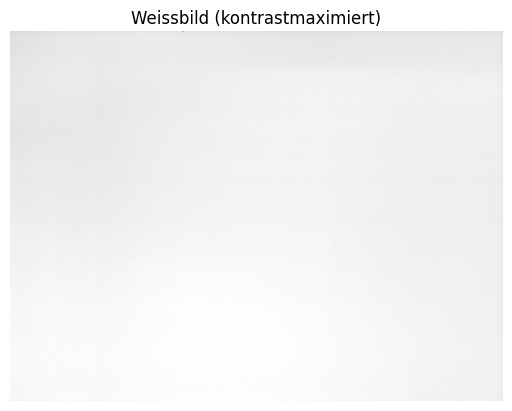

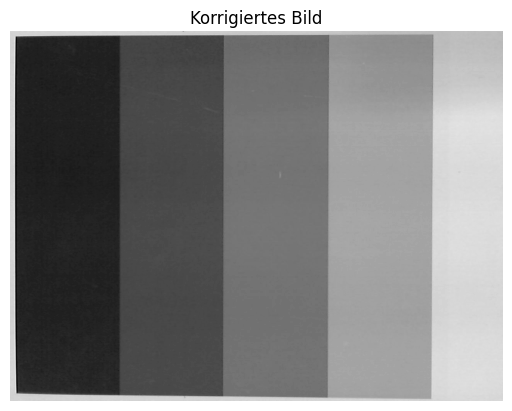

In [25]:
white_image_paths = [f"Weiss/Weiss{i}.png" for i in range(10)]  # Pfade der Weißbilder anpassen
white_images = read_images(white_image_paths)

mean_white_image = calculate_images_mean(white_images)

dark_image = read_image_as_double("Dunkelbild.png")

# Weißbild verarbeiten (Dunkelbild subtrahieren und kontrastmaximiert darstellen)
white_corrected = process_white_image(mean_white_image, dark_image)

# Weißbild normieren auf Mittelwert 1
normalized_white = normalize_white_image(white_corrected)

corrected_image = correct_image_with_white("CorrectedImage.png", dark_image, normalized_white)

show_cv2_as_image(corrected_image, "Korrigiertes Bild")

# Aufgabe 4: Pixelfehler

In [26]:
def find_pixel_defects(image, image_type="dark"):
    if image_type == "dark":
        hot_pixels = np.where(image > 250)
        stuck_pixels = np.where((image > 0) & (image < 5))
        return hot_pixels, stuck_pixels
    elif image_type == "white":
        dead_pixels = np.where(image < 5)
        return dead_pixels

In [27]:
def correct_pixel_defects(image, image_type="dark"):
    corrected_image = image.copy()
    pixel_defects = find_pixel_defects(image, image_type)
    if image_type == "dark":
        hot_pixels, stuck_pixels = pixel_defects
        for y, x in zip(hot_pixels[0], hot_pixels[1]):
            corrected_image[y, x] = np.median(image[max(0, y-1):y+2, max(0, x-1):x+2])
        for y, x in zip(stuck_pixels[0], stuck_pixels[1]):
            corrected_image[y, x] = np.median(image[max(0, y-1):y+2, max(0, x-1):x+2])
    elif image_type == "white":
        dead_pixels = pixel_defects
        for y, x in zip(dead_pixels[0], dead_pixels[1]):
            corrected_image[y, x] = np.median(image[max(0, y-1):y+2, max(0, x-1):x+2])
    return corrected_image

Stufe      Mittelwert      Standardabweichung  
0          35.96           3.79                
1          74.71           3.61                
2          120.53          10.58               
3          168.33          10.96               
4          218.12          4.89                


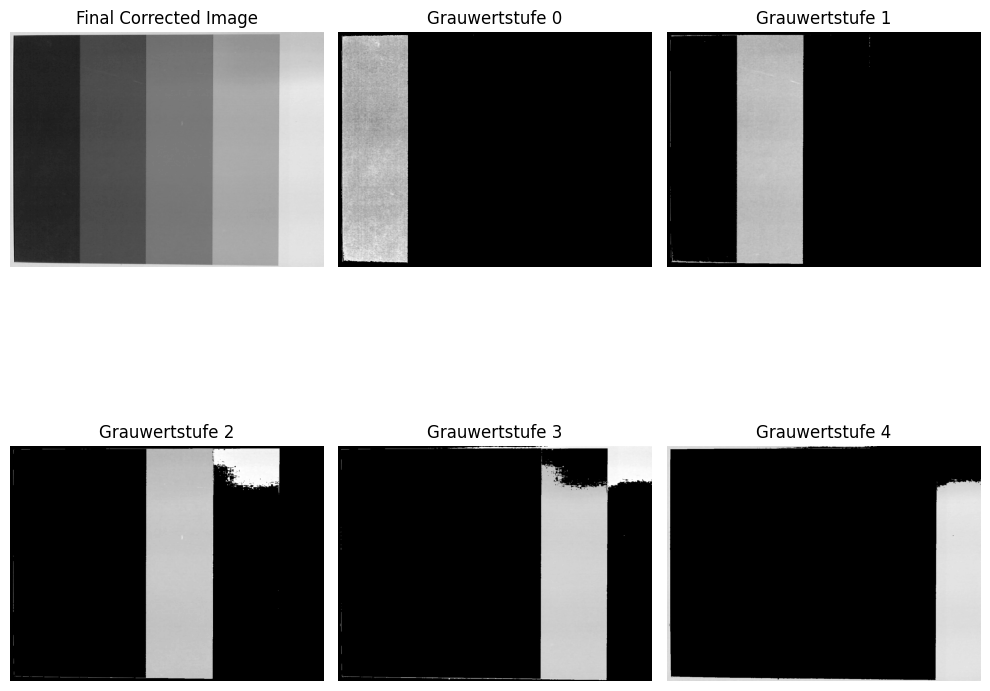

In [32]:
correct_image = cv2.imread('CorrectedImage_White.png', cv2.IMREAD_GRAYSCALE)

final_corrected_image = correct_pixel_defects(correct_image, image_type="dark")
final_corrected_image = correct_pixel_defects(final_corrected_image, image_type="white")

subimages = extract_sub_images(final_corrected_image, 5)

statistics = calculate_statistics(subimages)
create_table(statistics)

plt.figure(figsize=(10, 10))
plt.subplot(2, 3, 1)
plt.imshow(final_corrected_image, cmap='gray')
plt.title("Final Corrected Image")
plt.axis('off')

for i, s in enumerate(subimages):
    plt.subplot(2, 3, i + 2)
    plt.imshow(s, cmap='gray')
    plt.title(f"Grauwertstufe {i}")
    plt.axis('off')

plt.tight_layout()
plt.show()

cv2.waitKey(0)
cv2.destroyAllWindows()